In [26]:
import numpy as np
import matplotlib.pyplot as plt
import math


#get dimension for random pixel to generate
#get k value to generate random pixels with appropriate dimension
#data structure to hold which pixles are in which clusture
#2d array with tuple in each index. 
 #The index represents the pixel's location and the tuple value hold s(clustid, dist)
#check if the pixel already exists in the clusture, 
 #if not check distance, if distance of this k is < distance, update touple (newclusterid, newdist)
    
#distance = color (RGB) and coor(xy)
 #color compare all three channels


def get_cluster_RGB_XY(image):
    
    x,y = np.random.randint(0, image.shape[0]), np.random.randint(0, image.shape[1])
    
    r = image[x][y][0]
    g = image[x][y][1]
    b = image[x][y][2]
    
    return r,g,b,x,y
    


#image_table is an array of (clusterid, distance to its cluster, normalized distance)
#normalized distance is (color dist, pos dist). Only used for (rgbxy) features
#the image_table is used to assign pixels to each cluster and the distance to check the eligibility of updating the assigned cluster
def initialize_image_table(row, col):
    image_table = np.zeros((row,col,3), dtype=np.float32)
    return image_table
            
            
            
#clusters is an array of (clusterid, clusterRBG[], summedRBG[], current_iteration_pixel_count, prev_iteration_pixel_count, xy[], summedxy[])
#summedRGB[]: is the sum of rgb values of all current pixels in this cluster. Used with current_iteration_pixel_count to calculate the new clusterRGB values
#current_iteration_pixel_count: how many pixels are currently in the cluster. Used with summedRGB[] to calculate the new clusterRGB values
#prev_iteration_pixel_count: how many pixels were in the cluster the previous iteration. Used with current_iteration_pixel_count to know if convergence is reached
#xy[]: position. Only used for (rgbxy) features
#summedxy[]: sum of xy values of pixel in its cluster.  Used with current_iteration_pixel_count to calculate the new xy values
def initialize_clusters(image, k):
    clusters = []
    
    current_iteration_pixel_count = 0
    prev_iteration_pixel_count = 0
    
    #populate clusters
    for i in range(k):
        RGB = []
        r,g,b,x,y = get_cluster_RGB_XY(image)
        RGB.append(r)
        RGB.append(g)
        RGB.append(b)
        properties = []
        properties.append(i+1)
        properties.append(RGB)
        properties.append([0,0,0])
        properties.append(current_iteration_pixel_count)
        properties.append(prev_iteration_pixel_count)
        properties.append([x,y])
        properties.append([0,0])
        clusters.append(properties)
    
    #print(clusters)
    
    return clusters
        

#checks if convergence has been reached by comparing the previous iteration pixels to current iteration pixels
def convergence_reached(clusters):
    
    for k in range(len(clusters)):
        if abs(clusters[k][3] - clusters[k][4]) > 0 :
               return False
    
    return True
    
    
#updates the cluster RGB values and the number of pixels in its cluster    
def update_clusters(clusters, image, image_table, position_features=False):
    
    
    
    #get new mean
    for k in range(len(clusters)):
        if clusters[k][3] != 0:
            clusters[k][1][0] = int(clusters[k][2][0]/clusters[k][3])
            clusters[k][1][1] = int(clusters[k][2][1]/clusters[k][3])
            clusters[k][1][2] = int(clusters[k][2][2]/clusters[k][3])
            
            if position_features:
                clusters[k][5][0] = int(clusters[k][6][0]/clusters[k][3])
                clusters[k][5][1] = int(clusters[k][6][1]/clusters[k][3])
                
            
            
            #move current values to previous
            clusters[k][4] = clusters[k][3]
        

#gets the distance using the color difference formula from https://en.wikipedia.org/wiki/Color_difference
def color_distance(image_pixel, cluster_pixel):
    return math.sqrt(math.pow((cluster_pixel[0]-image_pixel[0]),2) + math.pow((cluster_pixel[1]-image_pixel[1]),2) + math.pow((cluster_pixel[2]-image_pixel[2]),2))

#gets positition distance 
def pos_distance(row, col, cluster_XY):
    return math.sqrt(math.pow((cluster_XY[0] - col), 2) + math.pow((cluster_XY[1] - row), 2))

def normalized_dist(color_dist, pos_dist):
    return (((color_dist + pos_dist) - 0)/((MAX_COLOR_DIST + MAX_POS_DIST) - 0))
    
#adds/updates the image_table 
def add_to_table(row, col, image_table, clusterid, color_dist, norm_dist, clusters,image_pixel, position_features=False):
   
    #table is empty at this index
    if image_table[row][col][0] == 0:
        if position_features:
            image_table[row][col][2] = norm_dist
            clusters[clusterid - 1][6][0] += row
            clusters[clusterid - 1][6][1] += col
        
        image_table[row][col][0] = clusterid
        image_table[row][col][1] = color_dist
        clusters[clusterid - 1][2][0] += image_pixel[0]
        clusters[clusterid - 1][2][1] += image_pixel[1]
        clusters[clusterid - 1][2][2] += image_pixel[2]
        clusters[clusterid - 1][3] += 1
        
    else:
        
        if position_features:
            if norm_dist < image_table[row][col][2]:
                
                if clusterid == image_table[row][col][0]:
                    image_table[row][col][2] = norm_dist
                    image_table[row][col][1] = color_dist
                else:
                    #remove pixel xy from its old cluster's summedxy[]
                    clusters[int(image_table[row][col][0]) - 1][6][0] -= row
                    clusters[int(image_table[row][col][0]) - 1][6][1] -= col
                    
                    #add pixel xy to its new cluster's summedxy[]
                    clusters[clusterid -1][6][0] += row
                    clusters[clusterid -1][6][1] += col
                    
                    
                    #removing old rgb value and decrementing its occurance
                    clusters[int(image_table[row][col][0]) - 1][2][0] -= image_pixel[0]
                    clusters[int(image_table[row][col][0]) - 1][2][1] -= image_pixel[1]
                    clusters[int(image_table[row][col][0]) - 1][2][2] -= image_pixel[2]
                    
                    clusters[int(image_table[row][col][0]) - 1][3] -= 1
                    
                    image_table[row][col][0] = clusterid
                    image_table[row][col][1] = color_dist
                    image_table[row][col][2] = norm_dist
                    
                    #add the new pixel to its cluster
                    clusters[clusterid - 1][2][0] += image_pixel[0]
                    clusters[clusterid - 1][2][1] += image_pixel[1]
                    clusters[clusterid - 1][2][2] += image_pixel[2]
                    
                    
                    #increment number of pixels in cluster
                    clusters[clusterid - 1][3] += 1
                    
                    
                
        #update if we find a better cluster and remove its rgb value from its respective cluster sum
        elif color_dist < image_table[row][col][1]:
           
            #already in cluster just update distance
            #happens when the pixel is still in the same cluster from previous iteration
            if clusterid == image_table[row][col][0]:
                image_table[row][col][1] = color_dist
            else:
                
                #removing old rgb value and decrementing its occurance
                clusters[int(image_table[row][col][0])  - 1][2][0] -= image_pixel[0]
                clusters[int(image_table[row][col][0])  - 1][2][1] -= image_pixel[1]
                clusters[int(image_table[row][col][0])  - 1][2][2] -= image_pixel[2]
                clusters[int(image_table[row][col][0])  - 1][3] -= 1
        
                #assign new id to (row, col) pixel and new distance
                image_table[row][col][0] = clusterid
                image_table[row][col][1] = color_dist
        
                #add the new pixel to its cluster
                clusters[clusterid - 1][2][0] += image_pixel[0]
                clusters[clusterid - 1][2][1] += image_pixel[1]
                clusters[clusterid - 1][2][2] += image_pixel[2]
                
                #increment number of pixels in cluster
                clusters[clusterid - 1][3] += 1
            


def segment(k, image, image_table, position_features=False):
    
    
    clusters = initialize_clusters(image, k)
    

    
    while(1):
    #for ever k loop through image and assign the needed info to image_table
        for k in range(len(clusters)):
        
            for row in range(image.shape[0]):
                for col in range(image.shape[1]):
                    
                    image_pixel = image[row][col]
                    
                    #get distance of image_pixel to cluster pixel
                    color_dist = color_distance(image_pixel, clusters[k][1])
                    
                    if position_features:
                        
                        pos_dist = pos_distance(row, col, clusters[k][5])
                        norm_dist = normalized_dist(color_dist, pos_dist)
                        add_to_table(row, col, image_table, clusters[k][0], color_dist, norm_dist, clusters, image_pixel, position_features=True)
                        
                    else:
                        
                        add_to_table(row, col, image_table, clusters[k][0], color_dist, 0, clusters, image_pixel)
    
            #print(clusters)
        
        #check if the number of pixels in each cluster has changed from previous iteration,
        # if it hasn't then we are done
        if convergence_reached(clusters):
            break
        
        if position_features:
            update_clusters(clusters, image, image_table, position_features=True)
        else:
            update_clusters(clusters, image, image_table)
        
        
        
        
                

def create_new_image(image, image_table, k, rows, cols):
    
    new_image = np.zeros_like(image)
    
    print(new_image.shape)
    colors = []
    #assign colors for each cluster for drawing
    for i in range (k):
        colors.append((np.random.randint(0,255), np.random.randint(0,255),np.random.randint(0,255)))
    
    #print(colors)
    #print(image_table)
    
    for r in range(rows):
        for c in range(cols):
            new_image[r][c][0] = colors[int(image_table[r][c][0]) - 1][0]
            new_image[r][c][1] = colors[int(image_table[r][c][0]) - 1][1]
            new_image[r][c][2] = colors[int(image_table[r][c][0]) - 1][2]
    
            
    return new_image  
    
            

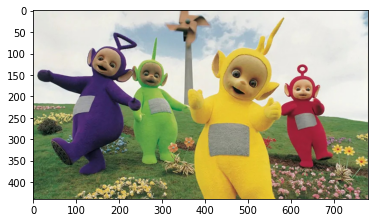

In [27]:
image = plt.imread('teletubbies_new.jpg')
plt.imshow(image)

<ipython-input-26-0731db774c79>:107: RuntimeWarning: overflow encountered in ubyte_scalars
  return math.sqrt(math.pow((cluster_pixel[0]-image_pixel[0]),2) + math.pow((cluster_pixel[1]-image_pixel[1]),2) + math.pow((cluster_pixel[2]-image_pixel[2]),2))


(439, 780, 3)


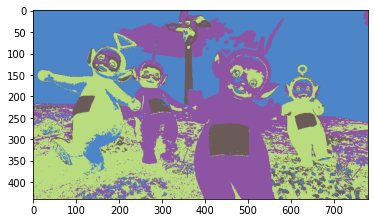

In [29]:
image_table = initialize_image_table(image.shape[0], image.shape[1])

k = 4
MIN_POS_DIST = 0
MAX_POS_DIST = pos_distance(0,0, [image.shape[0], image.shape[1]])
MIN_COLOR_DIST = 0
MAX_COLOR_DIST = color_distance([0,0,0], [255,255,255])


segment(k,image, image_table)
new_image = create_new_image(image, image_table, k, image.shape[0], image.shape[1])
plt.imshow(new_image)